## **Imports**

In [29]:
import os
import joblib
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

## **Paths & Global Variables**

In [30]:
ROOT_PATH = r"C:\Users\mario\OneDrive\Documents\Work\Side Hustles\Kaggle\titanic"

import sys

sys.path.append(ROOT_PATH)

from titanic.config import PROCESSED_DATA_DIR, MODELS_DIR

## **Reading Data**

In [31]:
os.chdir(PROCESSED_DATA_DIR)

total_df = pd.read_parquet("titanic_processed.parquet")

X_train = pd.read_parquet("X_train.parquet")
y_train = pd.read_parquet("y_train.parquet")

X_test = pd.read_parquet("X_test.parquet")
y_test = pd.read_parquet("y_test.parquet")

# **Decision Trees**

In [32]:
# From Logistic Regression
cols_to_remove = ["parents_children","num_rooms","age_min_max","age_group_ord","passenger_class_ord"]
X_train.drop(columns=cols_to_remove, inplace=True)
X_test.drop(columns=cols_to_remove, inplace=True)

## **Model Fitting**

In [33]:
dtree = DecisionTreeClassifier(max_depth=8, ccp_alpha=0.01,criterion='gini')

dtree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.01, max_depth=8)

### **Visualizing Decision Trees**

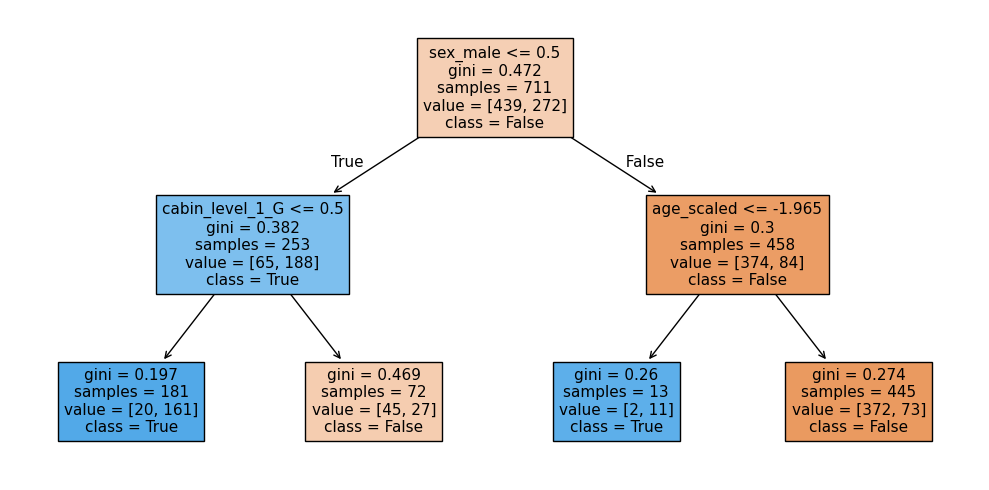

In [34]:
plt.figure(figsize=(10,5))
tree.plot_tree(dtree, feature_names = X_train.columns, max_depth=5, class_names = ['False', 'True'], label='all', filled=True)
plt.tight_layout()
plt.show()

In [35]:
print(tree.export_text(dtree, feature_names = X_train.columns))

|--- sex_male <= 0.50
|   |--- cabin_level_1_G <= 0.50
|   |   |--- class: True
|   |--- cabin_level_1_G >  0.50
|   |   |--- class: False
|--- sex_male >  0.50
|   |--- age_scaled <= -1.97
|   |   |--- class: True
|   |--- age_scaled >  -1.97
|   |   |--- class: False



## **Model Testing**

In [36]:
y_predicted = dtree.predict(X_test)
y_predicted_probs = dtree.predict_proba(X_test)[:, 1]

In [37]:
y_predicted_df = pd.DataFrame(y_predicted, columns=["predicted"], index=X_test.index)
y_predicted_probs_df = pd.DataFrame(y_predicted_probs, columns=["probability"], index=X_test.index)
y_predicted_df = pd.concat([y_predicted_df, y_predicted_probs_df], axis=1)
y_predicted_df.head()

,predicted,probability
passenger_id,,
161,False,0.164045
127,False,0.164045
429,False,0.164045
423,False,0.164045
566,False,0.164045


## **Evaluation Metrics**

In [38]:
test_conf_matrix = pd.DataFrame(
    confusion_matrix(y_test, y_predicted),
    index=["actual no", "actual yes"],
    columns=["predicted no", "predicted yes"],
)

test_conf_matrix

,predicted no,predicted yes
actual no,101,9
actual yes,28,40


In [39]:
metrics_dict = {
    "Accuracy": accuracy_score(y_test, y_predicted),
    "Precision": precision_score(y_test, y_predicted),
    "Recall": recall_score(y_test, y_predicted),
    "F1 Score": f1_score(y_test, y_predicted),
}

metrics_df = pd.DataFrame(
    metrics_dict.values(), index=metrics_dict.keys(), columns=["Value"]
)

roc_auc = roc_auc_score(y_test, y_predicted_probs)
gini = 2 * roc_auc - 1

metrics_df.loc["ROC AUC"] = roc_auc
metrics_df.loc["Gini"] = gini

metrics_df

,Value
Accuracy,0.792135
Precision,0.816327
Recall,0.588235
F1 Score,0.683761
ROC AUC,0.775067
Gini,0.550134


## **Model & Prediction Export**

In [40]:
os.chdir(MODELS_DIR)
# Save model
joblib.dump(dtree, "dtree-model.joblib")
y_predicted_df.to_parquet("dtree-y_predicted.parquet")